In [2]:
#gpu stuff and testing
import os
os.environ["CUDA_DEVICE_ORDER"]= "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "0"
##############################################
import tensorflow as tf
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
##############################################
tf.debugging.set_log_device_placement(True)

# Create some tensors
a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
c = tf.matmul(a, b)

print(c)

2.2.0
Num GPUs Available:  1
Executing op MatMul in device /job:localhost/replica:0/task:0/device:GPU:0
tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


In [3]:
import pandas as pd
import numpy as np

# Getting to business!

## Neural Network

### MACCS

In [5]:
#reshape maccs data
Xmac= pd.read_csv('../Data/maccscolumns.csv')
file= pd.read_csv('../Data/tox21mice_duplicate.csv')
y=file[['SR-HSE', 'NR-AR','SR-ARE', 'NR-Aromatase', 'NR-ER-LBD', 'NR-AhR', 'SR-MMP', 'NR-ER','NR-PPAR-gamma', 'SR-p53', 'SR-ATAD5', 'NR-AR-LBD']]

#splitting into train and test data
from sklearn.model_selection import train_test_split
Xmac_train, Xmac_test, y_train, y_test = train_test_split(Xmac, y, test_size = 0.3, random_state = 21)
Xmac_train_reshape= Xmac_train.astype("float32")
Xmac_test_reshape= Xmac_test.astype("float32")

In [6]:
len(Xmac_train)

8230

In [9]:
from tensorflow import keras
from tensorflow.keras import layers
macmodel = keras.Sequential(
    [
        layers.Embedding(len(Xmac_train),128,name="embedding_layer", input_length= len(Xmac.iloc[0])),
        layers.Dense(1300, activation="relu"),
        #layers.Dense(3, activation="relu"),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(12,activation='sigmoid', name="Output_layer"),
    ]
)

Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:

In [10]:
macmodel.summary()

#compile and fit the model
macmodel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#fit to model
macmodel.fit(Xmac_train_reshape, y_train, epochs=10, batch_size=48, verbose=0.1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_layer (Embedding)  (None, 167, 128)          1053440   
_________________________________________________________________
dense (Dense)                (None, 167, 1300)         167700    
_________________________________________________________________
flatten (Flatten)            (None, 217100)            0         
_________________________________________________________________
dropout (Dropout)            (None, 217100)            0         
_________________________________________________________________
Output_layer (Dense)         (None, 12)                2605212   
Total params: 3,826,352
Trainable params: 3,826,352
Non-trainable params: 0
_________________________________________________________________
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RangeDataset in dev

In [11]:
#using model.predict to do thresholding
macpred = macmodel.predict(Xmac_train_reshape)
macpred= tf.dtypes.cast(macpred>= 0.5, tf.int64)

#for training data
count=0
for i in range(len(y_train)):
    a= (y_train.iloc[i]==macpred[i])
    for j in range(len(a)):
        if (y_train.iloc[i][j]==macpred[i][j]):
            count= count+1
print("The accuracy for the training set is: ",(count)/(len(y_train)*12))

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_predict_function_4527 in device /job:localhost/replica:0/task:0/dev

In [12]:
#for test set
macpredtest= macmodel.predict(Xmac_test_reshape)
macpredtest= tf.dtypes.cast(macpredtest>= 0.5, tf.int64)
count=0
for i in range(len(y_test)):
    a= (y_test.iloc[i]==macpredtest[i])
    for j in range(len(a)):
        if (y_test.iloc[i][j]==macpredtest[i][j]):
            count= count+1
print("The accuracy for test score is: ", count/(len(y_test)*12))

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ConcatV2 in device /job:localhost/replica:0/task:0/device:GPU:0
The accuracy for test score is:  0.9333427815570673


In [13]:
loss, acc= macmodel.evaluate(Xmac_test_reshape, y_test, batch_size=128)
loss

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_1463115 in device /job:localhost/replica:0/task:0/device:GPU:0
28/28 [==============================] - 0s 8ms/step - loss: 0.1982 - accuracy

0.19823606312274933

### Random Forest

In [14]:
from sklearn.ensemble import RandomForestClassifier

In [15]:
Xm_test= Xmac_test
Xm_train= Xmac_train

In [16]:
#X_topo_train, X_topo_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 21)
classifier = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 42)
classifier.fit(Xm_train, y_train)
predict= classifier.predict(Xm_test)
count_misclassified = (y_test != predict).sum()
print("The number of wrongly predicted data is:\n",count_misclassified)
rfaccuracy_maccs= 1-(count_misclassified/len(y_test))
print("The accuracy of random forest is:\n", rfaccuracy_maccs)

The number of wrongly predicted data is:
 SR-HSE           174
NR-AR            122
SR-ARE           492
NR-Aromatase     214
NR-ER-LBD        154
NR-AhR           323
SR-MMP           383
NR-ER            343
NR-PPAR-gamma     81
SR-p53           216
SR-ATAD5          99
NR-AR-LBD        113
dtype: int64
The accuracy of random forest is:
 SR-HSE           0.950680
NR-AR            0.965420
SR-ARE           0.860544
NR-Aromatase     0.939342
NR-ER-LBD        0.956349
NR-AhR           0.908447
SR-MMP           0.891440
NR-ER            0.902778
NR-PPAR-gamma    0.977041
SR-p53           0.938776
SR-ATAD5         0.971939
NR-AR-LBD        0.967971
dtype: float64


### Logistic Regression

#### SR-HSE

In [17]:
from sklearn.linear_model import LogisticRegression
sr_hse= y_train['SR-HSE']
lm = LogisticRegression(multi_class='ovr', solver='liblinear')
lm.fit(Xm_train, sr_hse)
taccuracy1= lm.score(Xm_test, y_test['SR-HSE'])
print("The accuracy of the model is:",taccuracy1)

The accuracy of the model is: 0.9492630385487528


#### NR-AR 

In [18]:
nr_ar= y_train['NR-AR']
lm.fit(Xm_train, nr_ar)
taccuracy2= lm.score(Xm_test, y_test['NR-AR'])
print("The accuracy of the model is:",taccuracy2)

The accuracy of the model is: 0.9688208616780045


#### SR-ARE

In [19]:
sr_are= y_train['SR-ARE']
lm.fit(Xm_train, sr_are)
taccuracy3= lm.score(Xm_test, y_test['SR-ARE'])
print("The accuracy of the model is:",taccuracy3)

The accuracy of the model is: 0.8463718820861678


#### NR-Aromatase

In [20]:
nr_aromatase= y_train['NR-Aromatase']
lm.fit(Xm_train, nr_aromatase)
taccuracy4= lm.score(Xm_test, y_test['NR-Aromatase'])
print("The accuracy of the model is:",taccuracy4)

The accuracy of the model is: 0.9382086167800453


#### NR-ER-LBD

In [21]:
nr_erlbd= y_train['NR-ER-LBD']
lm.fit(Xm_train, nr_erlbd)
taccuracy5= lm.score(Xm_test, y_test['NR-ER-LBD'])
print("The accuracy of the model is:",taccuracy5)

The accuracy of the model is: 0.9546485260770975


#### NR-AhR

In [22]:
nr_ahr= y_train['NR-AhR']
lm.fit(Xm_train, nr_ahr)
taccuracy6= lm.score(Xm_test, y_test['NR-AhR'])
print("The accuracy of the model is:",taccuracy6)

The accuracy of the model is: 0.905045351473923


#### SR-MMP

In [23]:
sr_mmp= y_train['SR-MMP']
lm.fit(Xm_train, sr_mmp)
taccuracy7= lm.score(Xm_test, y_test['SR-MMP'])
print("The accuracy of the model is:",taccuracy7)

The accuracy of the model is: 0.8823696145124716


#### NR-ER

In [24]:
nr_er= y_train['NR-ER']
lm.fit(Xm_train, nr_er)
taccuracy8= lm.score(Xm_test, y_test['NR-ER'])
print("The accuracy of the model is:",taccuracy8)

The accuracy of the model is: 0.9056122448979592


#### NR-PPAR-gamma

In [25]:
nr_ppar= y_train['NR-PPAR-gamma']
lm.fit(Xm_train, nr_ppar)
taccuracy9= lm.score(Xm_test, y_test['NR-PPAR-gamma'])
print("The accuracy of the model is:",taccuracy9)

The accuracy of the model is: 0.9767573696145124


#### SR-p53

In [26]:
sr_p53= y_train['SR-p53']
lm.fit(Xm_train, sr_p53)
taccuracy10= lm.score(Xm_test, y_test['SR-p53'])
print("The accuracy of the model is:",taccuracy10)

The accuracy of the model is: 0.9362244897959183


#### SR-ATAD5

In [27]:
sr_atad5= y_train['SR-ATAD5']
lm.fit(Xm_train, sr_atad5)
taccuracy11= lm.score(Xm_test, y_test['SR-ATAD5'])
print("The accuracy of the model is:",taccuracy11)

The accuracy of the model is: 0.9693877551020408


#### NR-AR-LBD

In [28]:
nr_arlbd= y_train['NR-AR-LBD']
lm.fit(Xm_train, nr_arlbd)
taccuracy12= lm.score(Xm_test, y_test['NR-AR-LBD'])
print("The accuracy of the model is:",taccuracy12)

The accuracy of the model is: 0.9682539682539683


### SVM

In [29]:
from sklearn import svm

#### SR-HSE

In [30]:
sr_hse= y_train['SR-HSE']
sig = svm.SVC(kernel='sigmoid', C=1, decision_function_shape='ovr')
sig.fit(Xm_train, sr_hse)
tsaccuracy1= sig.score(Xm_test, y_test['SR-HSE'])
print("The accuracy of the model is:",tsaccuracy1)

The accuracy of the model is: 0.9095804988662132


#### NR-AR 

In [31]:
nr_ar= y_train['NR-AR']
sig.fit(Xm_train, nr_ar)
tsaccuracy2= sig.score(Xm_test, y_test['NR-AR'])
print("The accuracy of the model is:",tsaccuracy2)

The accuracy of the model is: 0.951530612244898


#### SR-ARE

In [32]:
sr_are= y_train['SR-ARE']
sig.fit(Xm_train, sr_are)
tsaccuracy3= sig.score(Xm_test, y_test['SR-ARE'])
print("The accuracy of the model is:",tsaccuracy3)

The accuracy of the model is: 0.7395124716553289


#### NR-Aromatase

In [33]:
nr_aromatase= y_train['NR-Aromatase']
sig.fit(Xm_train, nr_aromatase)
tsaccuracy4= sig.score(Xm_test, y_test['NR-Aromatase'])
print("The accuracy of the model is:",tsaccuracy4)

The accuracy of the model is: 0.8934240362811792


#### NR-ER-LBD

In [34]:
nr_erlbd= y_train['NR-ER-LBD']
sig.fit(Xm_train, nr_erlbd)
tsaccuracy5= sig.score(Xm_test, y_test['NR-ER-LBD'])
print("The accuracy of the model is:",tsaccuracy5)

The accuracy of the model is: 0.925453514739229


#### NR-AhR

In [35]:
nr_ahr= y_train['NR-AhR']
sig.fit(Xm_train, nr_ahr)
tsaccuracy6= sig.score(Xm_test, y_test['NR-AhR'])
print("The accuracy of the model is:",tsaccuracy6)

The accuracy of the model is: 0.873015873015873


#### SR-MMP

In [36]:
sr_mmp= y_train['SR-MMP']
sig.fit(Xm_train, sr_mmp)
tsaccuracy7= sig.score(Xm_test, y_test['SR-MMP'])
print("The accuracy of the model is:",tsaccuracy7)

The accuracy of the model is: 0.7970521541950113


#### NR-ER

In [37]:
nr_er= y_train['NR-ER']
sig.fit(Xm_train, nr_er)
tsaccuracy8= sig.score(Xm_test, y_test['NR-ER'])
print("The accuracy of the model is:",tsaccuracy8)

The accuracy of the model is: 0.8679138321995464


#### NR-PPAR-gamma

In [38]:
nr_ppar= y_train['NR-PPAR-gamma']
sig.fit(Xm_train, nr_ppar)
tsaccuracy9= sig.score(Xm_test, y_test['NR-PPAR-gamma'])
print("The accuracy of the model is:",tsaccuracy9)

The accuracy of the model is: 0.9744897959183674


#### SR-p53

In [39]:
sr_p53= y_train['SR-p53']
sig.fit(Xm_train, sr_p53)
tsaccuracy10= sig.score(Xm_test, y_test['SR-p53'])
print("The accuracy of the model is:",tsaccuracy10)

The accuracy of the model is: 0.8942743764172335


#### SR-ATAD5

In [40]:
sr_atad5= y_train['SR-ATAD5']
sig.fit(Xm_train, sr_atad5)
tsaccuracy11= sig.score(Xm_test, y_test['SR-ATAD5'])
print("The accuracy of the model is:",tsaccuracy11)

The accuracy of the model is: 0.9518140589569161


#### NR-AR-LBD

In [41]:
nr_arlbd= y_train['NR-AR-LBD']
sig.fit(Xm_train, nr_arlbd)
tsaccuracy12= sig.score(Xm_test, y_test['NR-AR-LBD'])
print("The accuracy of the model is:",tsaccuracy12)

The accuracy of the model is: 0.9520975056689343


#### Summary of maccs data

In [42]:
print("\033[1m" + "For Random Forest:"+ "\033[0m")
print(rfaccuracy_maccs)
print("\033[0m"+"----------")
print("\033[1m" + "For SVM:"+ "\033[0m")
print("\033[1m" + "For Logistic Regression:" + "\033[0m")
print("SR-HSE: \t", taccuracy1)
print("NR-AR: \t", taccuracy2)
print("SR-ARE: \t", taccuracy3)
print("NR-Aromatase: \t", taccuracy4)
print("NR-ER-LBD: \t", taccuracy5)
print("NR-AhR: \t", taccuracy6)
print("SR-MMP: \t", taccuracy7)
print("NR-ER: \t", taccuracy8)
print("NR-PPAR-gamma: \t", taccuracy9)
print("SR-p53: \t", taccuracy10)
print("SR-ATAD5: \t", taccuracy11)
print("NR-AR-LBD: \t", taccuracy12)
print("Average: \t", (taccuracy1+taccuracy2+taccuracy3+taccuracy4+taccuracy5+taccuracy6+taccuracy7+taccuracy8+taccuracy9+taccuracy10+taccuracy11+taccuracy12)/12)

print("\033[0m"+"----------")
print("\033[1m" + "For SVM:"+ "\033[0m")
print("SR-HSE: \t", tsaccuracy1)
print("NR-AR: \t", tsaccuracy2)
print("SR-ARE: \t", tsaccuracy3)
print("NR-Aromatase: \t", tsaccuracy4)
print("NR-ER-LBD: \t", tsaccuracy5)
print("NR-AhR: \t", tsaccuracy6)
print("SR-MMP: \t", tsaccuracy7)
print("NR-ER: \t", tsaccuracy8)
print("NR-PPAR-gamma: \t", tsaccuracy9)
print("SR-p53: \t", tsaccuracy10)
print("SR-ATAD5: \t", tsaccuracy11)
print("NR-AR-LBD: \t", tsaccuracy12)
print("Average: \t", (tsaccuracy1+tsaccuracy2+tsaccuracy3+tsaccuracy4+tsaccuracy5+tsaccuracy6+tsaccuracy7+tsaccuracy8+tsaccuracy9+tsaccuracy10+tsaccuracy11+tsaccuracy12)/12)


For Random Forest:
SR-HSE           0.950680
NR-AR            0.965420
SR-ARE           0.860544
NR-Aromatase     0.939342
NR-ER-LBD        0.956349
NR-AhR           0.908447
SR-MMP           0.891440
NR-ER            0.902778
NR-PPAR-gamma    0.977041
SR-p53           0.938776
SR-ATAD5         0.971939
NR-AR-LBD        0.967971
dtype: float64
----------
For SVM:
For Logistic Regression:
SR-HSE: 	 0.9492630385487528
NR-AR: 	 0.9688208616780045
SR-ARE: 	 0.8463718820861678
NR-Aromatase: 	 0.9382086167800453
NR-ER-LBD: 	 0.9546485260770975
NR-AhR: 	 0.905045351473923
SR-MMP: 	 0.8823696145124716
NR-ER: 	 0.9056122448979592
NR-PPAR-gamma: 	 0.9767573696145124
SR-p53: 	 0.9362244897959183
SR-ATAD5: 	 0.9693877551020408
NR-AR-LBD: 	 0.9682539682539683
Average: 	 0.9334136432350718
----------
For SVM:
SR-HSE: 	 0.9095804988662132
NR-AR: 	 0.951530612244898
SR-ARE: 	 0.7395124716553289
NR-Aromatase: 	 0.8934240362811792
NR-ER-LBD: 	 0.925453514739229
NR-AhR: 	 0.873015873015873
SR-MMP: 	 0.79

## Feature Selection

In [43]:
Xm= Xmac

### Random Forest Classifier

In [44]:
feature_importance= pd.DataFrame(classifier.feature_importances_,\
                                   index = Xm.columns,\
                                   columns=['importance']).sort_values('importance', ascending=False)
classifier.fit(Xm_train, y_train)
feature_scores = pd.Series(classifier.feature_importances_, index=Xm.columns).sort_values(ascending=False)

feature_scores

126    0.017816
146    0.017066
161    0.015281
132    0.014494
151    0.013698
         ...   
6      0.000012
5      0.000000
3      0.000000
2      0.000000
1      0.000000
Length: 167, dtype: float64

In [45]:
classifier.fit(Xm_train, y_train)
feature_scores = pd.Series(classifier.feature_importances_, index=Xm.columns).sort_values(ascending=False)

feature_scores

126    0.017816
146    0.017066
161    0.015281
132    0.014494
151    0.013698
         ...   
6      0.000012
5      0.000000
3      0.000000
2      0.000000
1      0.000000
Length: 167, dtype: float64

Text(0, 0.5, 'Number of Features (RFC)')

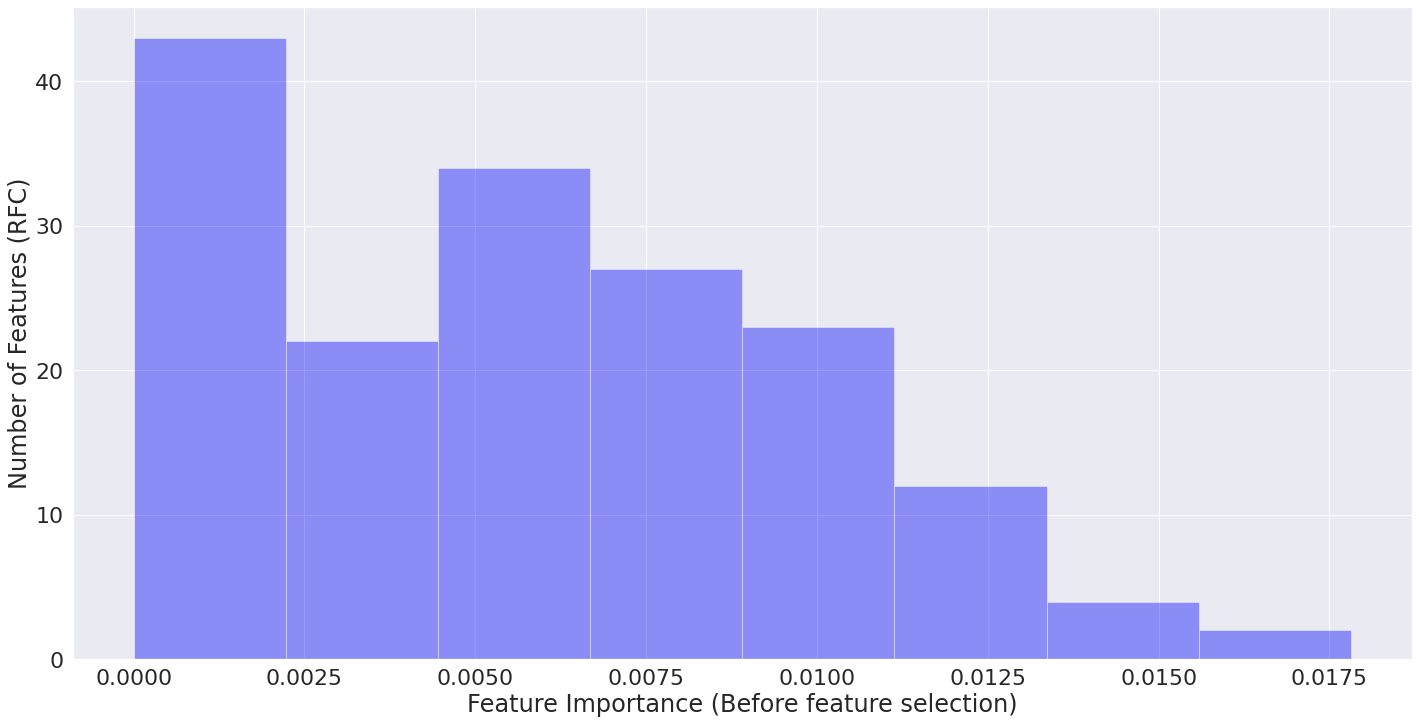

In [46]:
import seaborn as sb
import matplotlib.pyplot as plt
#histogram without feature selection
sb.set(font_scale=2)
f, axes = plt.subplots(1, 1, figsize=(24, 12))
a= sb.distplot(feature_scores, kde = False, color = "blue", axlabel="Feature Importance (Before feature selection)")
axes.set_ylabel("Number of Features (RFC)")

In [47]:
#select these indexes and get those respective features from X
features=feature_scores[0:100]
features

126    0.017816
146    0.017066
161    0.015281
132    0.014494
151    0.013698
         ...   
35     0.005295
50     0.005283
43     0.005107
111    0.004966
93     0.004956
Length: 100, dtype: float64

Text(0, 0.5, 'Number of Features (RFC)')

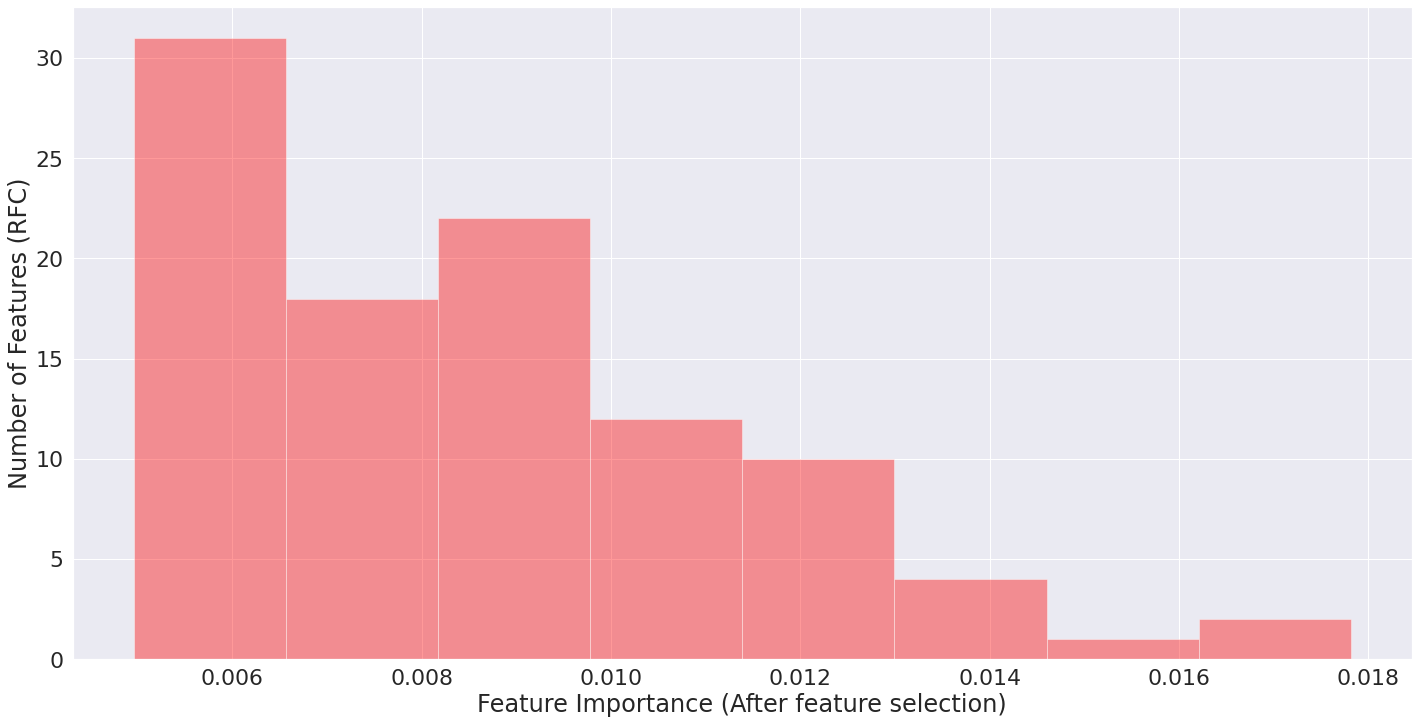

In [48]:
#plotting histogram for features after feature selection
import seaborn as sb
f, axes = plt.subplots(1, 1, figsize=(24, 12))
sb.distplot(features, kde = False, color = "red",axlabel="Feature Importance (After feature selection)")
axes.set_ylabel("Number of Features (RFC)")

#### After re-training the data

In [49]:
X_feat_train,X_feat_test,y_feat_train,y_feat_test=train_test_split(Xm[features.index],y,test_size=0.3,random_state=0)
newclassifier = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 42)
newclassifier.fit(X_feat_train,y_feat_train)
newrfpredict=newclassifier.predict(X_feat_test)
count_misclassified = (y_feat_test != newrfpredict).sum()
newrfaccuracy= 1-(count_misclassified/len(y_feat_test))
newrfaccuracy

SR-HSE           0.950964
NR-AR            0.971088
SR-ARE           0.867347
NR-Aromatase     0.941893
NR-ER-LBD        0.957766
NR-AhR           0.913832
SR-MMP           0.894558
NR-ER            0.907596
NR-PPAR-gamma    0.973073
SR-p53           0.943311
SR-ATAD5         0.973073
NR-AR-LBD        0.972506
dtype: float64

In [50]:
print("\033[1m" + "Random Forest:"+ "\033[0m")
print("\033[1m" + "Before feature selection:"+ "\033[0m")
print(rfaccuracy_maccs)
print("------------------")
print("\033[1m" + "After feature selection:"+ "\033[0m")
print(newrfaccuracy)

Random Forest:
Before feature selection:
SR-HSE           0.950680
NR-AR            0.965420
SR-ARE           0.860544
NR-Aromatase     0.939342
NR-ER-LBD        0.956349
NR-AhR           0.908447
SR-MMP           0.891440
NR-ER            0.902778
NR-PPAR-gamma    0.977041
SR-p53           0.938776
SR-ATAD5         0.971939
NR-AR-LBD        0.967971
dtype: float64
------------------
After feature selection:
SR-HSE           0.950964
NR-AR            0.971088
SR-ARE           0.867347
NR-Aromatase     0.941893
NR-ER-LBD        0.957766
NR-AhR           0.913832
SR-MMP           0.894558
NR-ER            0.907596
NR-PPAR-gamma    0.973073
SR-p53           0.943311
SR-ATAD5         0.973073
NR-AR-LBD        0.972506
dtype: float64


In [52]:
sum=0
for x in range(len(rfaccuracy_maccs)):
    sum= sum+ rfaccuracy_maccs[x]
average= sum/12
print("Average accuracy before feature selection is ", average)

sum=0
for x in range(len(newrfaccuracy)):
    sum= sum+ newrfaccuracy[x]
average= sum/12
print("Average accuracy after feature selection is ", average)

Average accuracy before feature selection is  0.9358938019652304
Average accuracy after feature selection is  0.9389172335600907


### RFE

In [53]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

This will take a really long while

In [54]:
rfe = RFE(lm, n_features_to_select= 100)
rfe = rfe.fit(Xm, y['SR-HSE'])

In [55]:
len(rfe.ranking_)

167

In [56]:
rfe.ranking_

array([68, 67, 66,  1, 65,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  6,  1,
        1,  1,  1, 60,  1,  1,  1,  1, 63,  1,  1,  1,  1, 48,  1, 20,  1,
       44,  1,  1,  1,  1,  1,  1,  1, 14,  1,  1, 10,  1,  1,  1,  1,  1,
        1,  1, 54, 33,  1,  1, 11,  1,  1,  1,  1,  2,  1,  1,  1,  1,  1,
        1,  1,  1, 58,  9,  1, 55, 22,  1,  1,  1, 46, 19,  1,  1,  1,  1,
       64, 30, 36,  1, 59,  1, 31, 40,  1,  1, 32,  1, 50,  1,  1, 27,  1,
       12,  1,  8,  1, 15, 37, 28, 38,  1,  1,  1,  1,  1, 53, 62, 39, 17,
        3, 26,  1, 21,  1,  1,  1,  1, 41,  1, 16,  1,  1, 34, 18,  1, 57,
       35,  1, 25, 49,  1, 24,  4, 52, 29, 42,  1, 43, 47, 23,  1,  7, 61,
        1, 51, 45,  1, 13,  1,  1,  1,  1,  1, 56,  1,  1,  5])

In [57]:
feature_importance= pd.DataFrame(rfe.ranking_,\
                                   index = Xm.columns,\
                                   columns=['importance']).sort_values('importance', ascending=True)
feature_importance.round(6)

,importance
84,1
74,1
131,1
132,1
71,1
...,...
86,64
5,65
3,66
2,67


In [58]:
feat_sel= feature_importance[0:100]
feat_sel

,importance
84,1
74,1
131,1
132,1
71,1
...,...
30,1
29,1
28,1
37,1


If ranking=1, it means that it is the best feature!

In [59]:
Xm[feat_sel.index]

,84,74,131,132,71,70,69,68,67,66,...,151,34,154,32,157,30,29,28,37,104
0,1,0,0,0,0,0,0,0,0,1,...,1,0,1,0,1,0,0,1,1,0
1,1,0,0,1,0,0,0,0,1,0,...,1,0,1,0,1,0,1,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,1,0,1,0,1,0,0,0,0,1
3,0,0,0,1,0,0,0,0,0,1,...,1,0,1,0,1,0,0,0,0,1
4,1,0,0,1,0,0,0,0,1,0,...,1,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11753,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,1,0,0,0,1,0
11754,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,1
11755,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,1,1
11756,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,1,0,0,0,0,0


In [60]:
Xt_rfe_train,Xt_rfe_test,yt_rfe_train,yt_rfe_test=train_test_split(Xm[feat_sel.index],y,test_size=0.3,random_state=0)

#### SR-HSE

In [61]:
sr_hse= yt_rfe_train['SR-HSE']
lm.fit(Xt_rfe_train, sr_hse)
newtaccuracy1=lm.score(Xt_rfe_test, yt_rfe_test['SR-HSE'])
print("The accuracy of the model is:",newtaccuracy1)

The accuracy of the model is: 0.9478458049886621


#### NR-AR 

In [62]:
nr_ar= yt_rfe_train['NR-AR']
lm.fit(Xt_rfe_train, nr_ar)
newtaccuracy2= lm.score(Xt_rfe_test, yt_rfe_test['NR-AR'])
print("The accuracy of the model is:",newtaccuracy2)

The accuracy of the model is: 0.9733560090702947


#### SR-ARE

In [63]:
sr_are= yt_rfe_train['SR-ARE']
lm.fit(Xt_rfe_train, sr_are)
newtaccuracy3= lm.score(Xt_rfe_test, yt_rfe_test['SR-ARE'])
print("The accuracy of the model is:",newtaccuracy3)

The accuracy of the model is: 0.8571428571428571


#### NR-Aromatase

In [64]:
nr_aromatase= yt_rfe_train['NR-Aromatase']
lm.fit(Xt_rfe_train, nr_aromatase)
newtaccuracy4= lm.score(Xt_rfe_test, yt_rfe_test['NR-Aromatase'])
print("The accuracy of the model is:",newtaccuracy4)

The accuracy of the model is: 0.9441609977324263


#### NR-ER-LBD

In [65]:
nr_erlbd= yt_rfe_train['NR-ER-LBD']
lm.fit(Xt_rfe_train, nr_erlbd)
newtaccuracy5= lm.score(Xt_rfe_test, yt_rfe_test['NR-ER-LBD'])
print("The accuracy of the model is:",newtaccuracy5)

The accuracy of the model is: 0.9518140589569161


#### NR-AhR

In [66]:
nr_ahr= yt_rfe_train['NR-AhR']
lm.fit(Xt_rfe_train, nr_ahr)
newtaccuracy6= lm.score(Xt_rfe_test, yt_rfe_test['NR-AhR'])
print("The accuracy of the model is:",newtaccuracy6)

The accuracy of the model is: 0.9143990929705216


#### SR-MMP

In [67]:
sr_mmp= yt_rfe_train['SR-MMP']
lm.fit(Xt_rfe_train, sr_mmp)
newtaccuracy7= lm.score(Xt_rfe_test, yt_rfe_test['SR-MMP'])
print("The accuracy of the model is:",newtaccuracy7)

The accuracy of the model is: 0.8835034013605442


#### NR-ER

In [68]:
nr_er= yt_rfe_train['NR-ER']
lm.fit(Xt_rfe_train, nr_er)
newtaccuracy8= lm.score(Xt_rfe_test, yt_rfe_test['NR-ER'])
print("The accuracy of the model is:",newtaccuracy8)

The accuracy of the model is: 0.907312925170068


#### NR-PPAR-gamma

In [69]:
nr_ppar= yt_rfe_train['NR-PPAR-gamma']
lm.fit(Xt_rfe_train, nr_ppar)
newtaccuracy9= lm.score(Xt_rfe_test, yt_rfe_test['NR-PPAR-gamma'])
print("The accuracy of the model is:",newtaccuracy9)

The accuracy of the model is: 0.9744897959183674


#### SR-p53

In [70]:
sr_p53= yt_rfe_train['SR-p53']
lm.fit(Xt_rfe_train, sr_p53)
newtaccuracy10= lm.score(Xt_rfe_test, yt_rfe_test['SR-p53'])
print("The accuracy of the model is:",newtaccuracy10)

The accuracy of the model is: 0.9410430839002267


#### SR-ATAD5

In [71]:
sr_atad5= yt_rfe_train['SR-ATAD5']
lm.fit(Xt_rfe_train, sr_atad5)
newtaccuracy11= lm.score(Xt_rfe_test, yt_rfe_test['SR-ATAD5'])
print("The accuracy of the model is:",newtaccuracy11)

The accuracy of the model is: 0.9722222222222222


#### NR-AR-LBD

In [72]:
nr_arlbd= yt_rfe_train['NR-AR-LBD']
lm.fit(Xt_rfe_train, nr_arlbd)
newtaccuracy12= lm.score(Xt_rfe_test, yt_rfe_test['NR-AR-LBD'])
print("The accuracy of the model is:",newtaccuracy12)

The accuracy of the model is: 0.9744897959183674


In [87]:
print("\033[1m" + "Logistic Regression:" + "\033[0m")
print("\033[1m" + "Before Feature Selection:" + "\033[0m")
print("SR-HSE: \t", taccuracy1)
print("NR-AR: \t", taccuracy2)
print("SR-ARE: \t", taccuracy3)
print("NR-Aromatase: \t", taccuracy4)
print("NR-ER-LBD: \t", taccuracy5)
print("NR-AhR: \t", taccuracy6)
print("SR-MMP: \t", taccuracy7)
print("NR-ER: \t", taccuracy8)
print("NR-PPAR-gamma: \t", taccuracy9)
print("SR-p53: \t", taccuracy10)
print("SR-ATAD5: \t", taccuracy11)
print("NR-AR-LBD: \t", taccuracy12)
print("Average: \t", (taccuracy1+taccuracy2+taccuracy3+taccuracy4+taccuracy5+taccuracy6+taccuracy7+taccuracy8+taccuracy9+taccuracy10+taccuracy11+taccuracy12)/12)

print("------------------------------\n")
print("\033[1m" + "After Feature Selection:" + "\033[0m")
print("SR-HSE: \t", newtaccuracy1)
print("NR-AR: \t", newtaccuracy2)
print("SR-ARE: \t", newtaccuracy3)
print("NR-Aromatase: \t", newtaccuracy4)
print("NR-ER-LBD: \t", newtaccuracy5)
print("NR-AhR: \t", newtaccuracy6)
print("SR-MMP: \t", newtaccuracy7)
print("NR-ER: \t", newtaccuracy8)
print("NR-PPAR-gamma: \t", newtaccuracy9)
print("SR-p53: \t", newtaccuracy10)
print("SR-ATAD5: \t", newtaccuracy11)
print("NR-AR-LBD: \t", newtaccuracy12)
print("Average: \t", (newtaccuracy1+newtaccuracy2+newtaccuracy3+newtaccuracy4+newtaccuracy5+newtaccuracy6+newtaccuracy7+newtaccuracy8+newtaccuracy9+newtaccuracy10+newtaccuracy11+newtaccuracy12)/12)


Logistic Regression:
Before Feature Selection:
SR-HSE: 	 0.9492630385487528
NR-AR: 	 0.9688208616780045
SR-ARE: 	 0.8463718820861678
NR-Aromatase: 	 0.9382086167800453
NR-ER-LBD: 	 0.9546485260770975
NR-AhR: 	 0.905045351473923
SR-MMP: 	 0.8823696145124716
NR-ER: 	 0.9056122448979592
NR-PPAR-gamma: 	 0.9767573696145124
SR-p53: 	 0.9362244897959183
SR-ATAD5: 	 0.9693877551020408
NR-AR-LBD: 	 0.9682539682539683
Average: 	 0.9334136432350718
------------------------------

After Feature Selection:
SR-HSE: 	 0.9478458049886621
NR-AR: 	 0.9733560090702947
SR-ARE: 	 0.8571428571428571
NR-Aromatase: 	 0.9441609977324263
NR-ER-LBD: 	 0.9518140589569161
NR-AhR: 	 0.9143990929705216
SR-MMP: 	 0.8835034013605442
NR-ER: 	 0.907312925170068
NR-PPAR-gamma: 	 0.9744897959183674
SR-p53: 	 0.9410430839002267
SR-ATAD5: 	 0.9722222222222222
NR-AR-LBD: 	 0.9744897959183674
Average: 	 0.9368150037792894


### Re-training SVM SVC

#### SR-HSE

In [74]:
sr_hse= yt_rfe_train['SR-HSE']
sig.fit(Xt_rfe_train, sr_hse)
newtsaccuracy1=sig.score(Xt_rfe_test, yt_rfe_test['SR-HSE'])
print("The accuracy of the model is:",newtsaccuracy1)

The accuracy of the model is: 0.9282879818594104


#### NR-AR 

In [75]:
nr_ar= yt_rfe_train['NR-AR']
sig.fit(Xt_rfe_train, nr_ar)
newtsaccuracy2= sig.score(Xt_rfe_test, yt_rfe_test['NR-AR'])
print("The accuracy of the model is:",newtsaccuracy2)

The accuracy of the model is: 0.953798185941043


#### SR-ARE

In [76]:
sr_are= yt_rfe_train['SR-ARE']
sig.fit(Xt_rfe_train, sr_are)
newtsaccuracy3= sig.score(Xt_rfe_test, yt_rfe_test['SR-ARE'])
print("The accuracy of the model is:",newtsaccuracy3)

The accuracy of the model is: 0.786281179138322


#### NR-Aromatase

In [77]:
nr_aromatase= yt_rfe_train['NR-Aromatase']
sig.fit(Xt_rfe_train, nr_aromatase)
newtsaccuracy4= sig.score(Xt_rfe_test, yt_rfe_test['NR-Aromatase'])
print("The accuracy of the model is:",newtsaccuracy4)

The accuracy of the model is: 0.9143990929705216


#### NR-ER-LBD

In [78]:
nr_erlbd= yt_rfe_train['NR-ER-LBD']
sig.fit(Xt_rfe_train, nr_erlbd)
newtsaccuracy5= sig.score(Xt_rfe_test, yt_rfe_test['NR-ER-LBD'])
print("The accuracy of the model is:",newtsaccuracy5)

The accuracy of the model is: 0.935374149659864


#### NR-AhR

In [79]:
nr_ahr= yt_rfe_train['NR-AhR']
sig.fit(Xt_rfe_train, nr_ahr)
newtsaccuracy6= sig.score(Xt_rfe_test, yt_rfe_test['NR-AhR'])
print("The accuracy of the model is:",newtsaccuracy6)

The accuracy of the model is: 0.8772675736961452


#### SR-MMP

In [80]:
sr_mmp= yt_rfe_train['SR-MMP']
sig.fit(Xt_rfe_train, sr_mmp)
newtsaccuracy7= sig.score(Xt_rfe_test, yt_rfe_test['SR-MMP'])
print("The accuracy of the model is:",newtsaccuracy7)

The accuracy of the model is: 0.8324829931972789


#### NR-ER

In [81]:
nr_er= yt_rfe_train['NR-ER']
sig.fit(Xt_rfe_train, nr_er)
newtsaccuracy8= sig.score(Xt_rfe_test, yt_rfe_test['NR-ER'])
print("The accuracy of the model is:",newtsaccuracy8)

The accuracy of the model is: 0.8577097505668935


#### NR-PPAR-gamma

In [82]:
nr_ppar= yt_rfe_train['NR-PPAR-gamma']
sig.fit(Xt_rfe_train, nr_ppar)
newtsaccuracy9= sig.score(Xt_rfe_test, yt_rfe_test['NR-PPAR-gamma'])
print("The accuracy of the model is:",newtsaccuracy9)

The accuracy of the model is: 0.9710884353741497


#### SR-p53

In [83]:
sr_p53= yt_rfe_train['SR-p53']
sig.fit(Xt_rfe_train, sr_p53)
newtsaccuracy10= sig.score(Xt_rfe_test, yt_rfe_test['SR-p53'])
print("The accuracy of the model is:",newtsaccuracy10)

The accuracy of the model is: 0.9149659863945578


#### SR-ATAD5

In [84]:
sr_atad5= yt_rfe_train['SR-ATAD5']
sig.fit(Xt_rfe_train, sr_atad5)
newtsaccuracy11= sig.score(Xt_rfe_test, yt_rfe_test['SR-ATAD5'])
print("The accuracy of the model is:",newtsaccuracy11)

The accuracy of the model is: 0.9648526077097506


#### NR-AR-LBD

In [85]:
nr_arlbd= yt_rfe_train['NR-AR-LBD']
sig.fit(Xt_rfe_train, nr_arlbd)
newtsaccuracy12= sig.score(Xt_rfe_test, yt_rfe_test['NR-AR-LBD'])
print("The accuracy of the model is:",newtsaccuracy12)

The accuracy of the model is: 0.9512471655328798


In [86]:
print("\033[1m" + "SVM SC Regression:" + "\033[0m")
print("\033[1m" + "Before Feature Selection:" + "\033[0m")
print("SR-HSE: \t", tsaccuracy1)
print("NR-AR: \t", tsaccuracy2)
print("SR-ARE: \t", tsaccuracy3)
print("NR-Aromatase: \t", tsaccuracy4)
print("NR-ER-LBD: \t", tsaccuracy5)
print("NR-AhR: \t", tsaccuracy6)
print("SR-MMP: \t", tsaccuracy7)
print("NR-ER: \t", tsaccuracy8)
print("NR-PPAR-gamma: \t", tsaccuracy9)
print("SR-p53: \t", tsaccuracy10)
print("SR-ATAD5: \t", tsaccuracy11)
print("NR-AR-LBD: \t", tsaccuracy12)
print("Average: \t", (tsaccuracy1+tsaccuracy2+tsaccuracy3+tsaccuracy4+tsaccuracy5+tsaccuracy6+tsaccuracy7+tsaccuracy8+tsaccuracy9+tsaccuracy10+tsaccuracy11+tsaccuracy12)/12)

print("------------------------------\n")
print("\033[1m" + "After Feature Selection:" + "\033[0m")
print("SR-HSE: \t", newtsaccuracy1)
print("NR-AR: \t", newtsaccuracy2)
print("SR-ARE: \t", newtsaccuracy3)
print("NR-Aromatase: \t", newtsaccuracy4)
print("NR-ER-LBD: \t", newtsaccuracy5)
print("NR-AhR: \t", newtsaccuracy6)
print("SR-MMP: \t", newtsaccuracy7)
print("NR-ER: \t", newtsaccuracy8)
print("NR-PPAR-gamma: \t", newtsaccuracy9)
print("SR-p53: \t", newtsaccuracy10)
print("SR-ATAD5: \t", newtsaccuracy11)
print("NR-AR-LBD: \t", newtsaccuracy12)
print("Average: \t", (newtsaccuracy1+newtsaccuracy2+newtsaccuracy3+newtsaccuracy4+newtsaccuracy5+newtsaccuracy6+newtsaccuracy7+newtsaccuracy8+newtsaccuracy9+newtsaccuracy10+newtsaccuracy11+newtsaccuracy12)/12)


SVM SC Regression:
Before Feature Selection:
SR-HSE: 	 0.9095804988662132
NR-AR: 	 0.951530612244898
SR-ARE: 	 0.7395124716553289
NR-Aromatase: 	 0.8934240362811792
NR-ER-LBD: 	 0.925453514739229
NR-AhR: 	 0.873015873015873
SR-MMP: 	 0.7970521541950113
NR-ER: 	 0.8679138321995464
NR-PPAR-gamma: 	 0.9744897959183674
SR-p53: 	 0.8942743764172335
SR-ATAD5: 	 0.9518140589569161
NR-AR-LBD: 	 0.9520975056689343
Average: 	 0.8941798941798943
------------------------------

After Feature Selection:
SR-HSE: 	 0.9282879818594104
NR-AR: 	 0.953798185941043
SR-ARE: 	 0.786281179138322
NR-Aromatase: 	 0.9143990929705216
NR-ER-LBD: 	 0.935374149659864
NR-AhR: 	 0.8772675736961452
SR-MMP: 	 0.8324829931972789
NR-ER: 	 0.8577097505668935
NR-PPAR-gamma: 	 0.9710884353741497
SR-p53: 	 0.9149659863945578
SR-ATAD5: 	 0.9648526077097506
NR-AR-LBD: 	 0.9512471655328798
Average: 	 0.9073129251700681


### Re-training neural network

In [ ]:
Xt_rfe_train,Xt_rfe_test,yt_rfe_train,yt_rfe_test

In [88]:
from tensorflow import keras
from tensorflow.keras import layers
newmacmodel = keras.Sequential(
    [
        layers.Embedding(len(Xt_rfe_train),128,name="embedding_layer", input_length= len(Xt_rfe_train.iloc[0])),
        layers.Dense(1300, activation="relu"),
        #layers.Dense(3, activation="relu"),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(12,activation='sigmoid', name="Output_layer"),
    ]
)

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0


In [89]:
newmacmodel.summary()

#compile and fit the model
newmacmodel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#fit to model
newmacmodel.fit(Xt_rfe_train, yt_rfe_train, epochs=10, batch_size=48, verbose=0.1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_layer (Embedding)  (None, 100, 128)          1053440   
_________________________________________________________________
dense_1 (Dense)              (None, 100, 1300)         167700    
_________________________________________________________________
flatten_1 (Flatten)          (None, 130000)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 130000)            0         
_________________________________________________________________
Output_layer (Dense)         (None, 12)                1560012   
Total params: 2,781,152
Trainable params: 2,781,152
Non-trainable params: 0
_________________________________________________________________
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in

In [90]:
#using model.predict to do thresholding
newmacpred = newmacmodel.predict(Xt_rfe_train)
newmacpred= tf.dtypes.cast(newmacpred>= 0.5, tf.int64)

#for training data
count=0
for i in range(len(yt_rfe_train)):
    a= (yt_rfe_train.iloc[i]==newmacpred[i])
    for j in range(len(a)):
        if (yt_rfe_train.iloc[i][j]==newmacpred[i][j]):
            count= count+1
print("The accuracy for the training set is: ",(count)/(len(yt_rfe_train)*12))

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_predict_function_1467695 in device /job:localhost/replica:0/task:0/

In [91]:
#for test set
newmacpredtest= newmacmodel.predict(Xt_rfe_test)
newmacpredtest= tf.dtypes.cast(newmacpredtest>= 0.5, tf.int64)
count=0
for i in range(len(yt_rfe_test)):
    a= (yt_rfe_test.iloc[i]==newmacpredtest[i])
    for j in range(len(a)):
        if (yt_rfe_test.iloc[i][j]==newmacpredtest[i][j]):
            count= count+1
print("The accuracy for test score is: ", count/(len(yt_rfe_test)*12))

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
The accuracy for test score is:  0.9373818972033258


In [92]:
loss, acc= newmacmodel.evaluate(Xt_rfe_test, yt_rfe_test, batch_size=128)
loss

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_2926284 in device /job:localhost/replica:0/task:0/device:GPU:0
28/28 [==============================] - 0s 6ms/step - loss: 0.1922 - accuracy

0.19217069447040558